# Variational Autoencoder implemented in JaX!

> Variational autoencoders can be a little bit tricky so they may be a good practice with JaX!

In [ ]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2023-05-01 13:46:43.807364: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 13:46:43.860179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 13:46:46.020888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from typing import Any, Callable, Sequence, Union
import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state

import optax

from clu import metrics
from ml_collections import ConfigDict

from einops import rearrange, reduce

from iqadatasets.datasets import *
from fxlayers.layers import *

## Get some data

> The interesting part is going to be the model/training definition, so we'll use MNIST to keep it as simple as possible.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train[:,:,:,None]/255.0
X_test = X_test[:,:,:,None]/255.0
Y_train = Y_train.astype(np.int32)
Y_test = Y_test.astype(np.int32)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [ ]:
dst_train = tf.data.Dataset.from_tensor_slices((X_train))
dst_val = tf.data.Dataset.from_tensor_slices((X_test))

In [ ]:
config = {
    "BATCH_SIZE": 32,
    "EPOCHS": 5,
    "LEARNING_RATE": 3e-4,
}
config = ConfigDict(config)
config

BATCH_SIZE: 32
EPOCHS: 5
LEARNING_RATE: 0.0003

In [ ]:
dst_train_rdy = dst_train.batch(config.BATCH_SIZE)
dst_val_rdy = dst_val.batch(config.BATCH_SIZE)

## Define the model we're going to use

> As we want to be able to encode and decode images separatelly, we should define the encoder and decoder modules.

In [ ]:
class Encoder(nn.Module):
    """CVAE Encoder"""
    latent_dim: int = 2

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        """Takes an image as inputs and encodes it as a mean and logvar."""
        outputs = nn.Conv(features=32, kernel_size=(5,5), strides=1, padding="SAME")(inputs)
        outputs = nn.relu(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = nn.Conv(features=64, kernel_size=(3,3), strides=1, padding="SAME")(outputs)
        outputs = nn.relu(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = rearrange(outputs, "b h w c -> b (h w c)")
        mean, logvar = nn.Dense(features=self.latent_dim)(outputs), nn.Dense(features=self.latent_dim)(outputs)
        return mean, logvar

In [ ]:
class Decoder(nn.Module):
    """CVAE Encoder"""
    
    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        """Takes a resampled point and outputs an image."""
        outputs = nn.Dense(features=3136)(inputs)
        outputs = nn.relu(outputs)
        outputs = rearrange(outputs, "b (h w c) -> b h w c", h=7, w=7, c=64)
        outputs = nn.ConvTranspose(features=32, kernel_size=(3,3), strides=(2,2), padding="SAME")(outputs)
        outputs = nn.relu(outputs)
        outputs = nn.ConvTranspose(features=1, kernel_size=(5,5), strides=(2,2), padding="SAME")(outputs)
        outputs = nn.relu(outputs)
        return outputs

In [ ]:
class CVAE(nn.Module):
    """Convolutional Variational Autoencoder"""
    latent_dim: int = 2

    def setup(self):
        self.encoder = Encoder(latent_dim=self.latent_dim)
        self.decoder = Decoder()

    def __call__(self,
                 inputs,
                 key=random.PRNGKey(0),
                 train=True,
                 **kwargs,
                 ):
        mean, logvar = self.encoder(inputs)
        z = self.resample(key, mean, logvar)
        outputs = self.decoder(z)
        ## We have to return the mean and logvar to calculate the loss during training
        ## but we don't need them during validation/testing.
        # return jnp.where(train, jnp.array([outputs, mean, logvar]), outputs)
        return outputs, mean, logvar
    
    @staticmethod
    def resample(key,
                 mean,
                 logvar,
                 ):
        return mean + jnp.exp(0.5*logvar)*random.normal(key, shape=logvar.shape)

## Define the metrics with `clu`

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    total_loss: metrics.Average.from_output("total_loss")
    reconstruction_loss: metrics.Average.from_output("reconstruction_loss")
    kl_div: metrics.Average.from_output("kl_div")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [ ]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    params = module.init(key, jnp.ones(input_shape))["params"]
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

We are going to define the KL Divergence ourselves (because it has a closed form when comparing two Normal distributions).

> See that we define it for a single sample but we will vmap it after.

In [ ]:
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

In [ ]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    inputs = batch
    def loss_fn(params):
        pred, mean, logvar = state.apply_fn({"params": params}, inputs)
        reconstruction_loss = optax.l2_loss(predictions=pred, targets=inputs).mean()
        kl_loss = jax.vmap(kl_divergence, in_axes=(0,0))(mean, logvar).mean()
        total_loss = reconstruction_loss + kl_loss
        return total_loss, (pred, reconstruction_loss, kl_loss)
    (total_loss, (pred, reconstruction_loss, kl_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    def compute_metrics(state):
        metric_updates = state.metrics.single_from_model_output(
            total_loss=total_loss, reconstruction_loss=reconstruction_loss, kl_div=kl_loss
        )
        metrics = state.metrics.merge(metric_updates)
        state = state.replace(metrics=metrics)
        return state
    state = compute_metrics(state)
    return state

In [ ]:
@jax.jit
def compute_metrics(*, state, batch):
    """Compute metrics for a single batch."""
    inputs = batch
    def loss_fn(params):
        pred, mean, logvar = state.apply_fn({"params": params}, inputs)
        reconstruction_loss = optax.l2_loss(predictions=pred, targets=inputs).mean()
        kl_loss = jax.vmap(kl_divergence, in_axes=(0,0))(mean, logvar).mean()
        total_loss = reconstruction_loss + kl_loss
        return total_loss, (pred, reconstruction_loss, kl_loss)
    total_loss, (pred, reconstruction_loss, kl_loss) = loss_fn(state.params)
    def _compute_metrics(state):
        metric_updates = state.metrics.single_from_model_output(
            total_loss=total_loss, reconstruction_loss=reconstruction_loss, kl_div=kl_loss
        )
        metrics = state.metrics.merge(metric_updates)
        state = state.replace(metrics=metrics)
        return state
    state = _compute_metrics(state)
    return state

## Train the model!

In [ ]:
state = create_train_state(CVAE(), random.PRNGKey(0), optax.adam(config.LEARNING_RATE), input_shape=(1,28,28,1))

In [ ]:
metrics_history = {
    "train_total_loss": [],
    "val_total_loss": [],
    "train_reconstruction_loss": [],
    "val_reconstruction_loss": [],
    "train_kl_div": [],
    "val_kl_div": [],
}

In [ ]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    # wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Total Loss: {metrics_history["train_total_loss"][-1]} | Reconstruction: {metrics_history["train_reconstruction_loss"][-1]} | KL: {metrics_history["train_kl_div"][-1]} [Val] Total Loss: {metrics_history["val_total_loss"][-1]} | Reconstruction: {metrics_history["val_reconstruction_loss"][-1]} | KL: {metrics_history["val_kl_div"][-1]}')
    # break

Epoch 0 -> [Train] Total Loss: 0.03677105903625488 | Reconstruction: 0.03485780954360962 | KL: 0.0019132716115564108 [Val] Total Loss: 0.03431036323308945 | Reconstruction: 0.03427962586283684 | KL: 3.073074185522273e-05
Epoch 1 -> [Train] Total Loss: 0.03368878364562988 | Reconstruction: 0.03368175029754639 | KL: 7.0610335569654126e-06 [Val] Total Loss: 0.034519486129283905 | Reconstruction: 0.03451821208000183 | KL: 1.2732785990010598e-06
Epoch 2 -> [Train] Total Loss: 0.033580709248781204 | Reconstruction: 0.03358020633459091 | KL: 5.684336201738915e-07 [Val] Total Loss: 0.03442131355404854 | Reconstruction: 0.03442039340734482 | KL: 9.191528533847304e-07
Epoch 3 -> [Train] Total Loss: 0.03352777287364006 | Reconstruction: 0.0335274338722229 | KL: 3.036886369045533e-07 [Val] Total Loss: 0.034319933503866196 | Reconstruction: 0.03431900963187218 | KL: 9.296860525864759e-07
Epoch 4 -> [Train] Total Loss: 0.03349529206752777 | Reconstruction: 0.0334949791431427 | KL: 3.5220733707319596

## Generate samples!

> To generate samples we have to generate normal distributed numbers and pass them through the decoder of the model.

In [ ]:
from functools import partial

In [ ]:
partial(jax.jit, static_argnums=(2))
def generate(key, n, params, latent_dim=2):
    latents = random.normal(key, shape=(n,latent_dim))
    pred = Decoder().apply(params, latents)
    return pred

In [ ]:
%time
g = generate(random.PRNGKey(0), 10, {"params": state.params["decoder"]}, latent_dim=2)

CPU times: user 42 µs, sys: 12 µs, total: 54 µs
Wall time: 107 µs


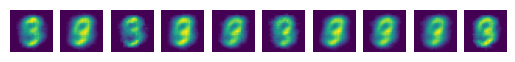

In [ ]:
fig, axes = plt.subplots(1,10)
for img, ax in zip(g, axes):
    ax.imshow(img)
    ax.axis("off")
plt.show()